<a href="https://colab.research.google.com/github/BryanBM8/SentimentAnalysis-MBTIClassification/blob/main/Salinan_dari_RM_MBTI_Classification_NaiveBayes_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk, csv, string, random, os, pickle
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.classify import NaiveBayesClassifier, accuracy
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from sklearn import svm
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/twitter_MBTI.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(10)



Mounted at /content/drive


,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
5,Frances Farmer Will Have Her Revenge On Seattl...,intj
6,🤣🤭🤣🤭🤣🤭🤣🤭 https://t.co/2a0tICP1yk|||Blind faith...,intj
7,proud of this one it goes hard https://t.co/RQ...,intj
8,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj
9,@JadMitri Good luck Jad!|||@ElsaYaghi A lawyer...,intj


In [ ]:
df.shape


(7811, 2)

In [ ]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


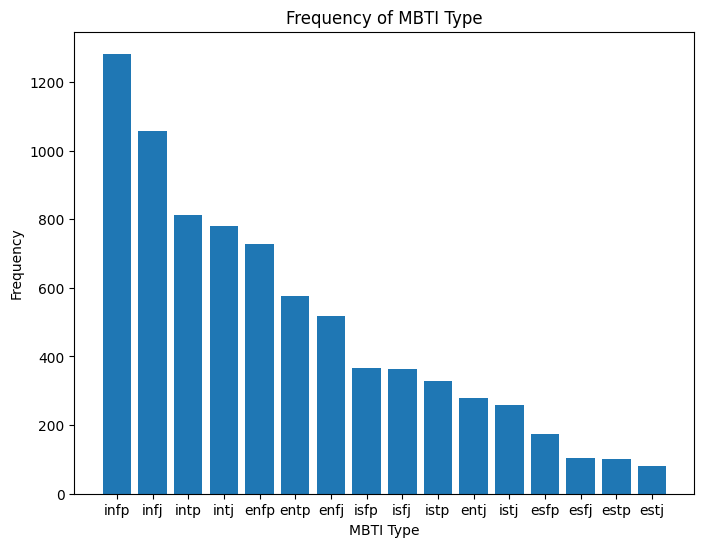

In [ ]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.title('Frequency of MBTI Type')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


X = df[['text']]
y = df['label']


target_size = 1200
label_counts = y.value_counts()


oversample_strategy = {label: target_size for label, count in label_counts.items() if count < target_size}

undersample_strategy = {label: target_size for label, count in label_counts.items() if count > target_size}


over_sampler = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=22)
under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=22)


X_over, y_over = over_sampler.fit_resample(X, y)


X_balanced, y_balanced = under_sampler.fit_resample(X_over, y_over)




In [ ]:
balanced_df = pd.DataFrame({
    'text': np.ravel(X_balanced),
    'label': y_balanced
})


print(balanced_df)

                                                    text label
0      https://t.co/FulnLrtflg|||Big shout out to our...  enfj
1      I apologize in advance for the person I'll bec...  enfj
2      @teaalovesnana You’re welcome🥰!|||@Jtaegikook2...  enfj
3      @zakiscorner Hahaha the hot take conveniently ...  enfj
4      @fearIessphoenix I like the other one better||...  enfj
...                                                  ...   ...
19195  @SavinTheBees https://t.co/Sfr8DwJO1a|||@Savin...  istp
19196  @deadkeiji i wanna play so bad i’m so good at ...  istp
19197  @narwhalent Kamu jg|||@xiaqvyu @UR5WIRLS Bantu...  istp
19198  one person followed me and 2 people unfollowed...  istp
19199  @innitsprime @glaive 🤭|||@glaiv4 its pride mon...  istp

[19200 rows x 2 columns]


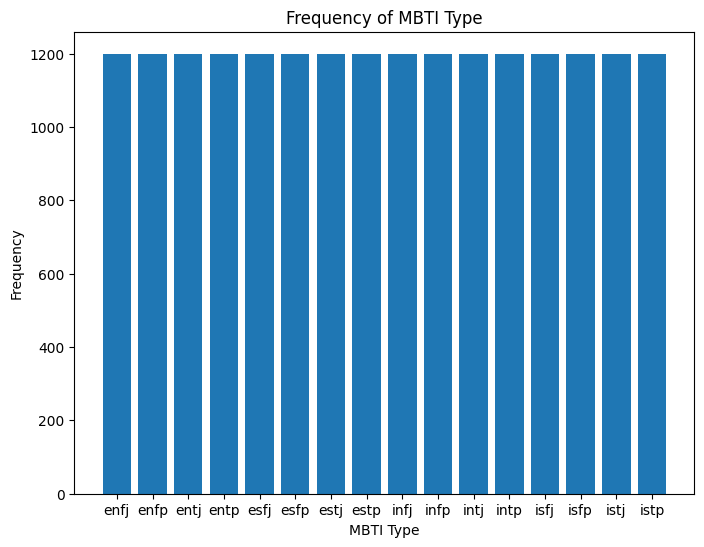

In [ ]:
label_counts = balanced_df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.title('Frequency of MBTI Type')
plt.show()

In [ ]:
mbti_labels = {
    'infj': 0, 'infp': 1, 'intj': 2, 'intp': 3,
    'isfj': 4, 'isfp': 5, 'istj': 6, 'istp': 7,
    'enfj': 8, 'enfp': 9, 'entj': 10, 'entp': 11,
    'esfj': 12, 'esfp': 13, 'estj': 14, 'estp': 15
}

def transform_label(data):
  label = data['label'].lower()
  num = mbti_labels[label]
  return num

balanced_df['label'] = balanced_df.apply(transform_label, axis=1)

print(balanced_df['label'])

0        8
1        8
2        8
3        8
4        8
        ..
19195    7
19196    7
19197    7
19198    7
19199    7
Name: label, Length: 19200, dtype: int64


In [ ]:
print(balanced_df['text'])



0        https://t.co/FulnLrtflg|||Big shout out to our...
1        I apologize in advance for the person I'll bec...
2        @teaalovesnana You’re welcome🥰!|||@Jtaegikook2...
3        @zakiscorner Hahaha the hot take conveniently ...
4        @fearIessphoenix I like the other one better||...
                               ...                        
19195    @SavinTheBees https://t.co/Sfr8DwJO1a|||@Savin...
19196    @deadkeiji i wanna play so bad i’m so good at ...
19197    @narwhalent Kamu jg|||@xiaqvyu @UR5WIRLS Bantu...
19198    one person followed me and 2 people unfollowed...
19199    @innitsprime @glaive 🤭|||@glaiv4 its pride mon...
Name: text, Length: 19200, dtype: object


In [ ]:
def combine_tweets(text):
    return text.replace('|||', ' ')

In [ ]:
balanced_df['text'] = balanced_df['text'].apply(combine_tweets)
print(balanced_df['text'])

0        https://t.co/FulnLrtflg Big shout out to our d...
1        I apologize in advance for the person I'll bec...
2        @teaalovesnana You’re welcome🥰! @Jtaegikook2 Y...
3        @zakiscorner Hahaha the hot take conveniently ...
4        @fearIessphoenix I like the other one better @...
                               ...                        
19195    @SavinTheBees https://t.co/Sfr8DwJO1a @SavinTh...
19196    @deadkeiji i wanna play so bad i’m so good at ...
19197    @narwhalent Kamu jg @xiaqvyu @UR5WIRLS Bantuin...
19198    one person followed me and 2 people unfollowed...
19199    @innitsprime @glaive 🤭 @glaiv4 its pride month...
Name: text, Length: 19200, dtype: object


In [ ]:
#Removes links, tags (@username), emojis, punctuation
def preprocess(text):
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'\bhttps\S+\b', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

balanced_df['text'] = balanced_df['text'].apply(preprocess)
print(balanced_df['text'])

0        Big shout out to our dearest MC and PR the liv...
1        I apologize in advance for the person Ill beco...
2        Youre welcome Yes we will for sure Same Jazz I...
3        Hahaha the hot take conveniently forgets there...
4        I like the other one better Yes Boris wont kno...
                               ...                        
19195    W Sickos the both of you I misread your tweet ...
19196    i wanna play so bad im so good at it STOP CAYS...
19197    Kamu jg Bantuin apa lagi bff Gays Yessirrrrr H...
19198    one person followed me and 2 people unfollowed...
19199    its pride month tho JUST COME TO INDIANA SO U ...
Name: text, Length: 19200, dtype: object


In [ ]:
ENGLISH_STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation
LEMMATIZER = WordNetLemmatizer()

In [ ]:
def preprocess_2(text):
  text = word_tokenize(text)
  text = [word for word in text if word not in ENGLISH_STOPWORDS]
  text = [LEMMATIZER.lemmatize(word) for word in text]
  text = [word for word in text if word not in string.punctuation]
  text = [word for word in text if word.isalpha()]
  return text
balanced_df['text'] = balanced_df['text'].apply(preprocess_2)
print(balanced_df['text'])

0        [Big, shout, dearest, MC, PR, live, party, yan...
1        [I, apologize, advance, person, Ill, become, F...
2        [Youre, welcome, Yes, sure, Same, Jazz, Im, go...
3        [Hahaha, hot, take, conveniently, forgets, who...
4        [I, like, one, better, Yes, Boris, wont, know,...
                               ...                        
19195    [W, Sickos, I, misread, tweet, Nvm, I, see, Wh...
19196    [wan, na, play, bad, im, good, STOP, CAYSE, HE...
19197    [Kamu, jg, Bantuin, apa, lagi, bff, Gays, Yess...
19198    [one, person, followed, people, unfollowed, au...
19199    [pride, month, tho, JUST, COME, TO, INDIANA, S...
Name: text, Length: 19200, dtype: object


In [ ]:
train, eval = train_test_split(balanced_df,train_size=0.8,stratify=balanced_df['label'], random_state = 42)

def tokens_to_features(tokens):
    return {token: True for token in tokens}

train_set = [(tokens_to_features(tokens), label) for tokens, label in zip(train['text'], train['label'])]
eval_set = [(tokens_to_features(tokens), label) for tokens, label in zip(eval['text'], eval['label'])]

print(train_set[0:10])
print(eval_set[0:10])



[({'I': True, 'know': True, 'thank': True, 'letting': True, 'Oh': True, 'God': True, 'please': True, 'No': True, 'spider': True, 'Ok': True, 'sorry': True, 'happened': True, 'also': True, 'hope': True, 'youre': True, 'ok': True, 'Yup': True, 'glad': True, 'someone': True, 'understands': True, 'scary': True, 'Hugs': True, 'back': True, 'killed': True, 'metal': True, 'water': True, 'bottle': True, 'even': True, 'though': True, 'practically': True, 'ready': True, 'burst': True, 'tear': True, 'scared': True, 'Im': True, 'dont': True, 'think': True, 'sleep': True, 'It': True, 'showed': True, 'bed': True, 'next': True, 'got': True, 'literally': True, 'screaming': True, 'fir': True, 'Random': True, 'understandable': True, 'Happy': True, 'birthday': True, 'fun': True, 'The': True, 'anime': True, 'opening': True, 'Fairy': True, 'Tail': True, 'Snow': True, 'pokemon': True, 'putting': True, 'Idk': True, 'yah': True, 'apparently': True, 'still': True, 'alive': True, 'Ill': True, 'post': True, 'stu

In [ ]:
classifier = NaiveBayesClassifier.train(train_set)

predictions = [classifier.classify(features) for features, label in eval_set]
true_labels = [label for features, label in eval_set]

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.73      0.33      0.46       240
           1       0.53      0.15      0.23       240
           2       0.35      0.78      0.49       240
           3       0.98      0.48      0.65       240
           4       0.95      0.88      0.91       240
           5       0.98      0.88      0.93       240
           6       1.00      0.93      0.96       240
           7       0.96      0.88      0.92       240
           8       0.85      0.83      0.84       240
           9       0.48      0.73      0.58       240
          10       0.91      0.93      0.92       240
          11       0.56      0.78      0.65       240
          12       1.00      1.00      1.00       240
          13       0.99      0.98      0.98       240
          14       1.00      1.00      1.00       240
          15       1.00      1.00      1.00       240

    accuracy                           0.78      3840
   macro avg       0.83   

In [ ]:
X = balanced_df['text']
y = balanced_df['label']
X = [' '.join(tokens) for tokens in X]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

clf = svm.SVC(kernel='linear')
clf.fit(X_train_vect, y_train)


y_pred = clf.predict(X_test_vect)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       225
           1       0.46      0.40      0.43       233
           2       0.76      0.71      0.74       256
           3       0.71      0.66      0.68       256
           4       0.89      0.97      0.93       244
           5       0.89      0.93      0.91       210
           6       0.92      0.97      0.94       248
           7       0.93      0.95      0.94       217
           8       0.82      0.85      0.84       235
           9       0.74      0.74      0.74       229
          10       0.91      0.97      0.94       249
          11       0.86      0.85      0.85       245
          12       0.98      1.00      0.99       239
          13       0.92      1.00      0.96       228
          14       0.99      1.00      0.99       269
          15       0.98      1.00      0.99       257

    accuracy                           0.84      3840
   macro avg       0.83   

In [ ]:
def predict_user_input(user_input):
    # Preprocess the input data (tokenize if needed)
    # Here, we assume the input is a space-separated string of tokens
    input_vect = vectorizer.transform([user_input])

    # Predict the label
    prediction = clf.predict(input_vect)

    return prediction[0]

# Example usage:
user_input = "Your input text here"
predicted_label = predict_user_input(user_input)
print(f"Predicted label: {predicted_label}")

Predicted label: 3


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn import svm

# Load the CSV file containing user input
user_input_df = pd.read_csv('/content/sample_data/stephenasmith.csv')  # Update path to the CSV file

user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess)
user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess_2)

# Join lists back into strings
user_input_df['tweet'] = user_input_df['tweet'].apply(lambda x: ' '.join(x))

# Combine all the preprocessed texts into a single string
user_input_texts = user_input_df['tweet']
combined_text = ' '.join(user_input_texts)

# Assuming 'vectorizer' and 'clf' are already trained and defined
# Vectorize the combined text
combined_text_vect = vectorizer.transform([combined_text])

# Predict the label for the combined text
predicted_label = clf.predict(combined_text_vect)

print(f"Predicted label for the combined text: {predicted_label[0]}")


Predicted label for the combined text: 8


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

# Load the CSV file containing user input
user_input_df = pd.read_csv('/content/sample_data/Adele.csv')  # Update path to the CSV file

user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess)
user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess_2)

# Join lists back into strings
user_input_df['tweet'] = user_input_df['tweet'].apply(lambda x: ' '.join(x))

# Combine all the preprocessed texts into a single string
user_input_texts = user_input_df['tweet']
combined_text = ' '.join(user_input_texts)

# Assuming 'vectorizer' and 'clf' are already trained and defined
# Vectorize the combined text
combined_text_vect = vectorizer.transform([combined_text])

# Predict the label for the combined text
predicted_label = clf.predict(combined_text_vect)

print(f"Predicted label for the combined text: {predicted_label[0]}")


Predicted label for the combined text: 9


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

# Load the CSV file containing user input
user_input_df = pd.read_csv('/content/sample_data/russwest44.csv')  # Update path to the CSV file

user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess)
user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess_2)

# Join lists back into strings
user_input_df['tweet'] = user_input_df['tweet'].apply(lambda x: ' '.join(x))

# Combine all the preprocessed texts into a single string
user_input_texts = user_input_df['tweet']
combined_text = ' '.join(user_input_texts)

# Assuming 'vectorizer' and 'clf' are already trained and defined
# Vectorize the combined text
combined_text_vect = vectorizer.transform([combined_text])

# Predict the label for the combined text
predicted_label = clf.predict(combined_text_vect)

print(f"Predicted label for the combined text: {predicted_label[0]}")



Predicted label for the combined text: 10


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

# Load the CSV file containing user input
user_input_df = pd.read_csv('/content/sample_data/psy_oppa.csv')  # Update path to the CSV file

user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess)
user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess_2)

# Join lists back into strings
user_input_df['tweet'] = user_input_df['tweet'].apply(lambda x: ' '.join(x))

# Combine all the preprocessed texts into a single string
user_input_texts = user_input_df['tweet']
combined_text = ' '.join(user_input_texts)

# Assuming 'vectorizer' and 'clf' are already trained and defined
# Vectorize the combined text
combined_text_vect = vectorizer.transform([combined_text])

# Predict the label for the combined text
predicted_label = clf.predict(combined_text_vect)

print(f"Predicted label for the combined text: {predicted_label[0]}")


Predicted label for the combined text: 4


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

# Load the CSV file containing user input
user_input_df = pd.read_csv('/content/sample_data/KingJames.csv')  # Update path to the CSV file

user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess)
user_input_df['tweet'] = user_input_df['tweet'].apply(preprocess_2)

# Join lists back into strings
user_input_df['tweet'] = user_input_df['tweet'].apply(lambda x: ' '.join(x))

# Combine all the preprocessed texts into a single string
user_input_texts = user_input_df['tweet']
combined_text = ' '.join(user_input_texts)

# Assuming 'vectorizer' and 'clf' are already trained and defined
# Vectorize the combined text
combined_text_vect = vectorizer.transform([combined_text])

# Predict the label for the combined text
predicted_label = clf.predict(combined_text_vect)

print(f"Predicted label for the combined text: {predicted_label[0]}")



Predicted label for the combined text: 8
